In [1]:
import sys
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import SimpleITK as sitk

sys.path.append("..")
from datasets.utils import misc, sitk_utils


# Load NLST labels into a DataFrame

In [2]:
labels_df = pd.read_csv("/mnt/ssd1/NLST/NLST_clinical_whole.csv")
labels_df.head()

/home/ibrahim/anaconda3/envs/lightningbringer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (47,264,284,285,286,287,288,853,854,961,978,985) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,pid,finalgrouping,days_t0tot1,days_t1tot2,scr_days0,scr_days1,scr_days2,gender_mbs,race_mbs,cigsmok_mbs,...,treat,treat_year,disease_post_surg,treat_days,rad_stop_days,cctab5v2,_st,_d,_t,_t0
0,126955,CC1,392.0,NaN,0.0,392.0,NaN,male,White,Former,...,2.0,1.0,0.0,475.0,NaN,Z. CC1/CC2,1,0.0,60.000000,0.0
1,209029,CC1,435.0,NaN,0.0,435.0,NaN,female,White,Former,...,1.0,1.0,NaN,661.0,708.0,Z. CC1/CC2,1,0.0,60.000000,0.0
2,218391,CC1,428.0,NaN,0.0,428.0,NaN,male,White,Former,...,2.0,1.0,0.0,512.0,NaN,Z. CC1/CC2,1,0.0,60.000000,0.0
3,216940,CC1,371.0,NaN,0.0,371.0,NaN,female,White,Former,...,2.0,1.0,0.0,579.0,NaN,Z. CC1/CC2,1,1.0,60.000000,0.0
4,101068,CC1,319.0,NaN,17.0,336.0,NaN,male,White,Current,...,2.0,1.0,0.0,621.0,NaN,Z. CC1/CC2,1,1.0,5.519634,0.0


# Load mask sizes into a DataFrame
`mask_sizes.pkl` generated by `check_mask_sizes.py`

In [3]:
with open ('mask_sizes.pkl', 'rb') as fp:
    mask_sizes = pickle.load(fp)

masks_df = pd.DataFrame.from_dict({
    "path": list(mask_sizes.keys()),
    "height": [elem[0] for elem in list(mask_sizes.values())],
    "width": [elem[1] for elem in list(mask_sizes.values())],
    "depth": [elem[2] for elem in list(mask_sizes.values())]
    })
masks_df.head()

,path,height,width,depth
0,/mnt/ssd1/NLST/lung_masks/T2/109731_img.nrrd,133,148,11
1,/mnt/ssd1/NLST/lung_masks/T2/100871_img.nrrd,216,235,104
2,/mnt/ssd1/NLST/lung_masks/T2/119952_img.nrrd,201,242,103
3,/mnt/ssd1/NLST/lung_masks/T2/111705_img.nrrd,238,352,106
4,/mnt/ssd1/NLST/lung_masks/T2/204547_img.nrrd,185,265,98


# Distribution of HWD

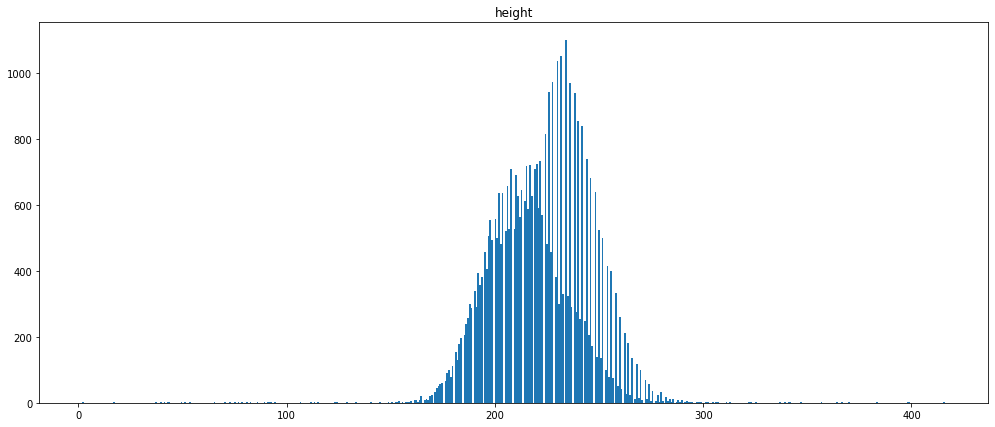

In [4]:
plt.figure(figsize=(17, 7))
plt.title("height")
plt.hist(list(masks_df["height"]), bins=500)
plt.show()

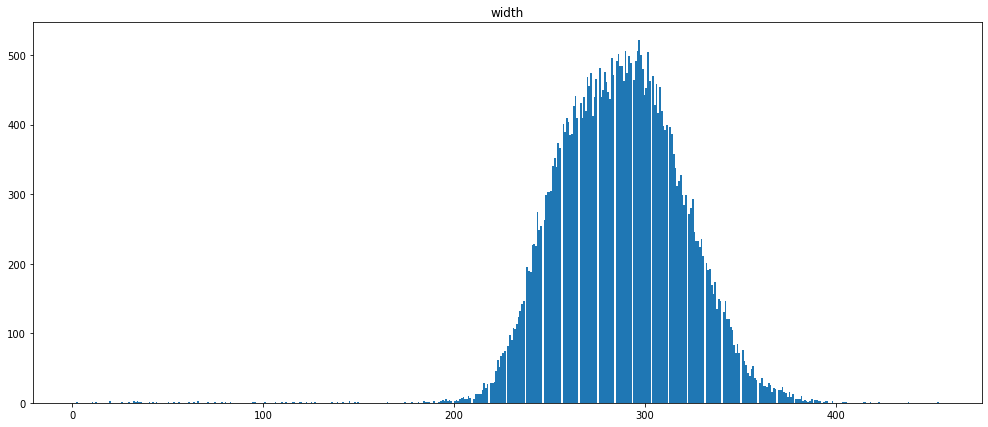

In [5]:
plt.figure(figsize=(17, 7))
plt.title("width")
plt.hist(list(masks_df["width"]), bins=500)
plt.show()

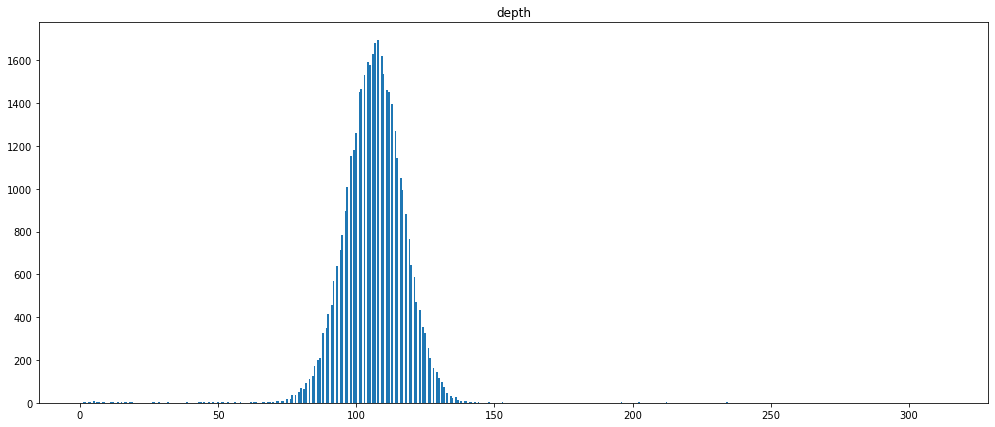

In [6]:
plt.figure(figsize=(17, 7))
plt.title("depth")
plt.hist(list(masks_df["depth"]), bins=500)
plt.show()

# Packyear distribution

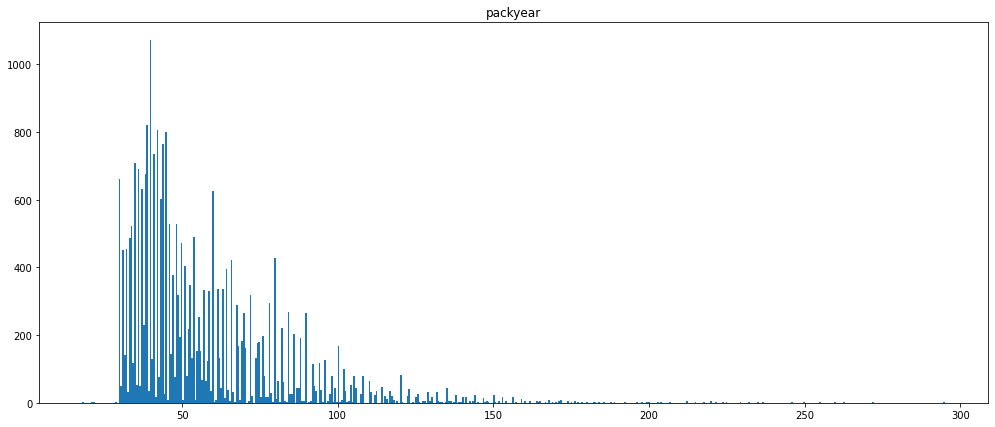

In [7]:
plt.figure(figsize=(17, 7))
plt.title("packyear")
plt.hist(list(labels_df["packyear"]), bins=500)
plt.show()


# HU distribution in masked-out lungs

In [8]:
SCANS_DIR = Path("/mnt/ssd1/NLST/nrrd/")
MASKS_DIR = Path("/mnt/ssd1/NLST/lung_masks/")

def get_masked_out_scan(timepoint_and_name, hu_min=-1000, erode=False):
    scan_path = SCANS_DIR / timepoint_and_name
    mask_path = MASKS_DIR / timepoint_and_name
    
    scan = sitk.ReadImage(str(scan_path))
    mask = sitk.ReadImage(str(mask_path))

    # Originally, mask has a label for each lung, here we combine them into a single label
    mask = sitk.Clamp(mask, upperBound=1)

    # Get the bounding box of the mask
    start, end = misc.get_bounding_box_of_mask(mask)
    
    # Erosion of the mask - less lung wall in the image
    if erode:
        mask = sitk.BinaryErode(mask)

    # Mask out everything except lungs
    scan = sitk_utils.apply_mask(scan, mask, masking_value=0, outside_value=hu_min)
    # Crop the masked scan using the bounding box
    scan = sitk_utils.slice_image(scan, start=start, end=end)
    return scan
    

## Masked lungs, no mask erosion

In [9]:
SLICE_IDX = 50
SCAN = "T0/100004_img.nrrd"

(98, 316, 462)


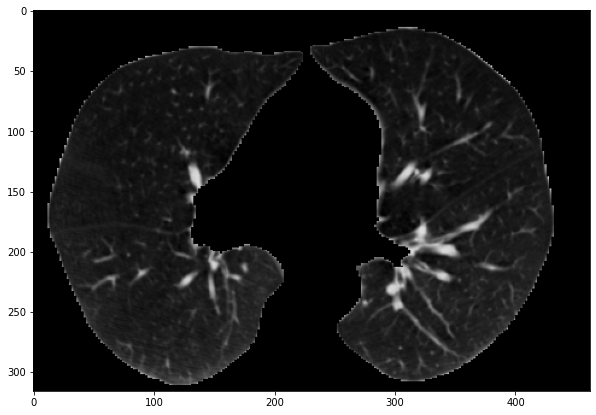

In [10]:
scan = sitk_utils.get_npy(get_masked_out_scan(SCAN))
plt.figure(figsize=(17, 7))
plt.imshow(scan[SLICE_IDX], cmap="gray")
print(scan.shape)

## Masked lungs, with mask erosion

(98, 316, 462)


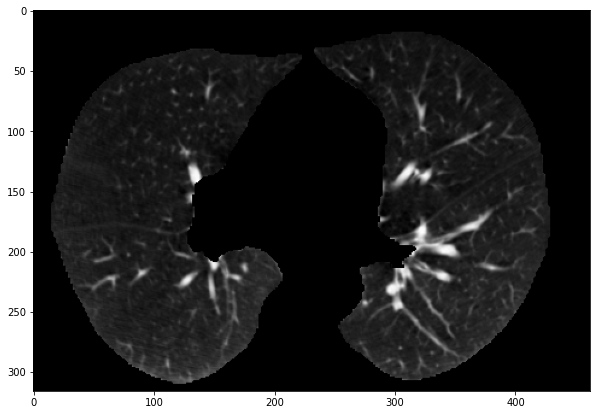

In [11]:
scan_eroded = sitk_utils.get_npy(get_masked_out_scan(SCAN, erode=True))
plt.figure(figsize=(17, 7))
plt.imshow(scan_eroded[SLICE_IDX], cmap="gray")
print(scan_eroded.shape)

Min: -1024 Max: 484


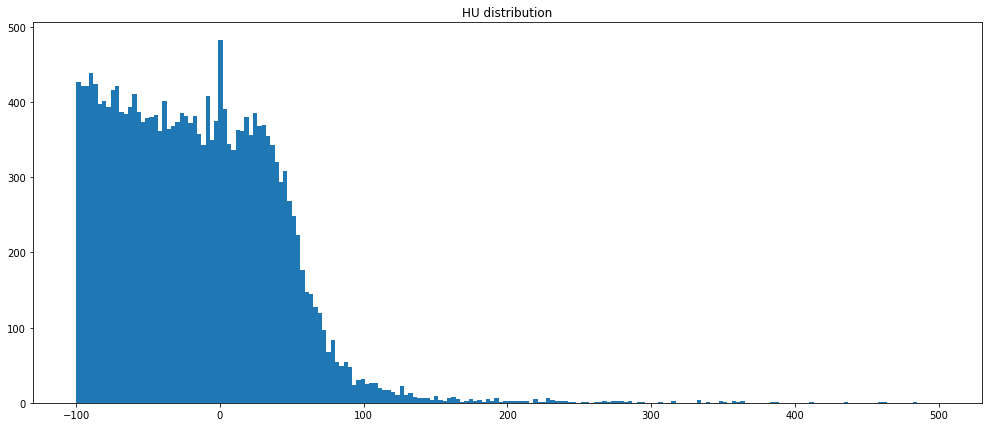

In [12]:
flattened = scan.flatten()
plt.figure(figsize=(17, 7))
plt.hist(flattened, bins=200, range=[-100, 500])
plt.title("HU distribution")
print("Min:", flattened.min(), "Max:", flattened.max())

Min: -1024 Max: 169


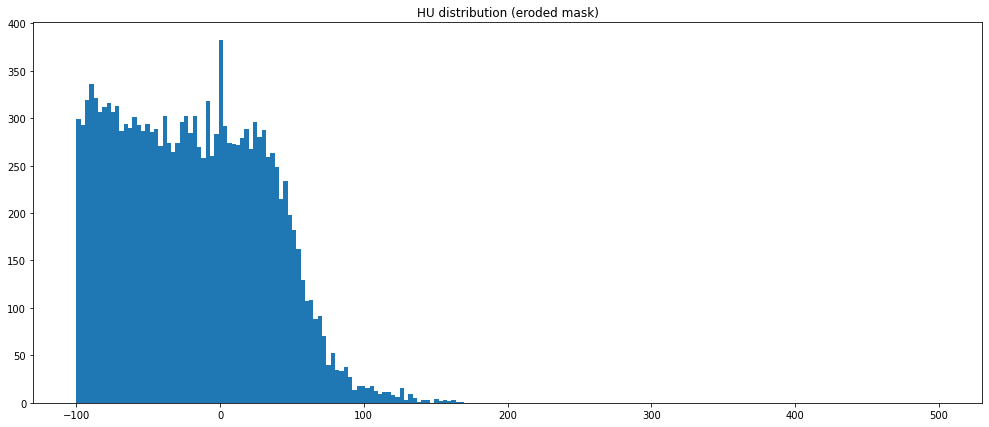

In [13]:
flattened_eroded = scan_eroded.flatten()
plt.figure(figsize=(17, 7))
plt.hist(flattened_eroded, bins=200, range=[-100, 500])
plt.title("HU distribution (eroded mask)")
print("Min:", flattened_eroded.min(), "Max:", flattened_eroded.max())

##

In [14]:
# SCAN = Path("T0/100015_img.nrrd")
# out_dir = Path("./") / SCAN.parent.name
# out_dir.mkdir(exist_ok=True)

# out_path = out_dir / str(SCAN.name).replace("_img.nrrd", "_masked.nrrd")
# sitk_utils.write(get_masked_out_scan(SCAN, erode=False), out_path)

# out_path = out_dir / str(SCAN.name).replace("_img.nrrd", "_masked_eroded.nrrd")
# sitk_utils.write(get_masked_out_scan(SCAN, erode=True), out_path)